# Option Analysis - Liquid Option Discovery & Stats

Find the most liquid and traded BTC option and analyze its trading patterns.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

# Set styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
pd.set_option('display.max_columns', None)

In [4]:
# Load aggregated option metadata to find the most liquid ones
parsed_dir = Path('../parsed/options/')

if not parsed_dir.exists():
    print("Parsed options directory not found. Please run 3_parse_options.py first.")
else:
    print("Loading aggregated option metadata...")
    meta_feather = parsed_dir / 'options_metadata.feather'
    meta_csv = parsed_dir / 'options_metadata.csv'
    if meta_feather.exists():
        df_options = pd.read_feather(meta_feather)
    elif meta_csv.exists():
        df_options = pd.read_csv(meta_csv)
    else:
        raise FileNotFoundError("options_metadata.feather (or CSV) not found. Re-run 3_parse_options.py")

    # Convert to DataFrame for analysis (already a DataFrame)
    df_options['expiry_date'] = pd.to_datetime(df_options['expiry_date'], format='ISO8601')
    df_options['first_trade'] = pd.to_datetime(df_options['first_trade'], format='ISO8601')
    df_options['last_trade'] = pd.to_datetime(df_options['last_trade'], format='ISO8601')
    df_options['trading_days'] = (df_options['last_trade'] - df_options['first_trade']).dt.days + 1
    df_options['avg_trades_per_day'] = df_options['total_trades'] / df_options['trading_days']

    print(f"Loaded metadata for {len(df_options)} options")

    print("\n=== TOP 10 MOST LIQUID OPTIONS (by total trades) ===")
    top_by_trades = df_options.nlargest(10, 'total_trades')[['instrument', 'total_trades', 'total_volume', 'trading_days', 'avg_trades_per_day']]
    display(top_by_trades)

    print("\n=== TOP 10 MOST LIQUID OPTIONS (by average daily trades) ===")
    top_by_daily = df_options.nlargest(10, 'avg_trades_per_day')[['instrument', 'total_trades', 'total_volume', 'trading_days', 'avg_trades_per_day']]
    display(top_by_daily)

Loading aggregated option metadata...
Loaded metadata for 73299 options

=== TOP 10 MOST LIQUID OPTIONS (by total trades) ===


,instrument,total_trades,total_volume,trading_days,avg_trades_per_day
44375,BTC-27DEC24-100000-C,18046,74524.9,365,49.441096
30822,BTC-29DEC23-45000-C,15181,53677.0,350,43.374286
17348,BTC-24JUN22-20000-P,14200,36547.8,365,38.904110
54035,BTC-27JUN25-110000-C,13236,40898.6,365,36.263014
22247,BTC-30SEP22-20000-P,13148,23228.9,267,49.243446
49414,BTC-28MAR25-100000-C,12809,43955.1,365,35.093151
11879,BTC-31DEC21-100000-C,11772,33086.6,370,31.816216
22642,BTC-30DEC22-15000-P,11256,34999.9,339,33.203540
24654,BTC-31MAR23-30000-C,10878,42091.0,329,33.063830
25778,BTC-30SEP22-18000-P,10745,26878.0,109,98.577982



=== TOP 10 MOST LIQUID OPTIONS (by average daily trades) ===


,instrument,total_trades,total_volume,trading_days,avg_trades_per_day
28168,BTC-27SEP22-19500-C,1339,1169.4,2,669.5
47515,BTC-1MAR24-60000-P,1040,1877.3,2,520.0
66733,BTC-1MAR25-79000-P,493,282.7,1,493.0
25934,BTC-19JUN22-19500-C,479,588.3,1,479.0
28166,BTC-27SEP22-19000-C,875,1229.8,2,437.5
25732,BTC-16JUN22-18000-P,855,7243.3,2,427.5
30811,BTC-15JAN23-21000-C,843,955.0,2,421.5
31866,BTC-17FEB23-25250-C,392,1022.7,1,392.0
33601,BTC-2APR23-28500-C,783,749.8,2,391.5
28440,BTC-8OCT22-19500-P,777,1418.6,2,388.5


## 2. Select and Load Most Liquid Option

In [5]:
# Select the most liquid option (highest total trades)
most_liquid = df_options.loc[df_options['total_trades'].idxmax()]
option_name = most_liquid['instrument']

print(f"SELECTED OPTION: {option_name}")
print(f"   Total trades: {most_liquid['total_trades']:,}")
print(f"   Total volume: {most_liquid['total_volume']:.2f}")
print(f"   Trading period: {most_liquid['trading_days']} days")
print(f"   Average daily trades: {most_liquid['avg_trades_per_day']:.1f}")
print(f"   Option type: {most_liquid['option_type']}")
print(f"   Strike: ${most_liquid['strike_price']:,}")
print(f"   Expiry: {most_liquid['expiry_date'].date()}")

# Load the trade data
trades_file = parsed_dir / option_name / 'trades.feather'
df_trades = pd.read_feather(trades_file)

# Add datetime column
df_trades['datetime'] = pd.to_datetime(df_trades['timestamp'], unit='us', utc=True)
df_trades['date'] = df_trades['datetime'].dt.date
df_trades['hour'] = df_trades['datetime'].dt.hour

print(f"\nLoaded {len(df_trades):,} trades")
print(f"   Date range: {df_trades['datetime'].min()} to {df_trades['datetime'].max()}")
print(f"   Price range: ${df_trades['price'].min():.4f} - ${df_trades['price'].max():.4f}")

# Show sample data
display(df_trades.head())

SELECTED OPTION: BTC-27DEC24-100000-C
   Total trades: 18,046
   Total volume: 74524.90
   Trading period: 365 days
   Average daily trades: 49.4
   Option type: CALL
   Strike: $100,000
   Expiry: 2024-12-27

Loaded 18,046 trades
   Date range: 2023-12-29 03:10:06.799000+00:00 to 2024-12-27 04:35:03.628000+00:00
   Price range: $0.0001 - $0.2130


,timestamp,id,price,quantity,is_buyer_maker,instrument,iv,mark_price,index_price,datetime,date,hour
0,1703819406799000,277060973,0.0590,0.1,False,BTC-27DEC24-100000-C,66.20,0.062096,42561.10,2023-12-29 03:10:06.799000+00:00,2023-12-29,3
1,1703841061202000,277125542,0.0595,0.1,False,BTC-27DEC24-100000-C,66.51,0.061764,42529.96,2023-12-29 09:11:01.202000+00:00,2023-12-29,9
2,1703849547189000,277140429,0.0620,2.0,True,BTC-27DEC24-100000-C,66.76,0.061240,42884.22,2023-12-29 11:32:27.189000+00:00,2023-12-29,11
3,1703855300972000,277146517,0.0600,0.5,False,BTC-27DEC24-100000-C,66.23,0.061917,42840.10,2023-12-29 13:08:20.972000+00:00,2023-12-29,13
4,1703855300975000,277146518,0.0600,2.5,True,BTC-27DEC24-100000-C,66.23,0.061917,42840.10,2023-12-29 13:08:20.975000+00:00,2023-12-29,13


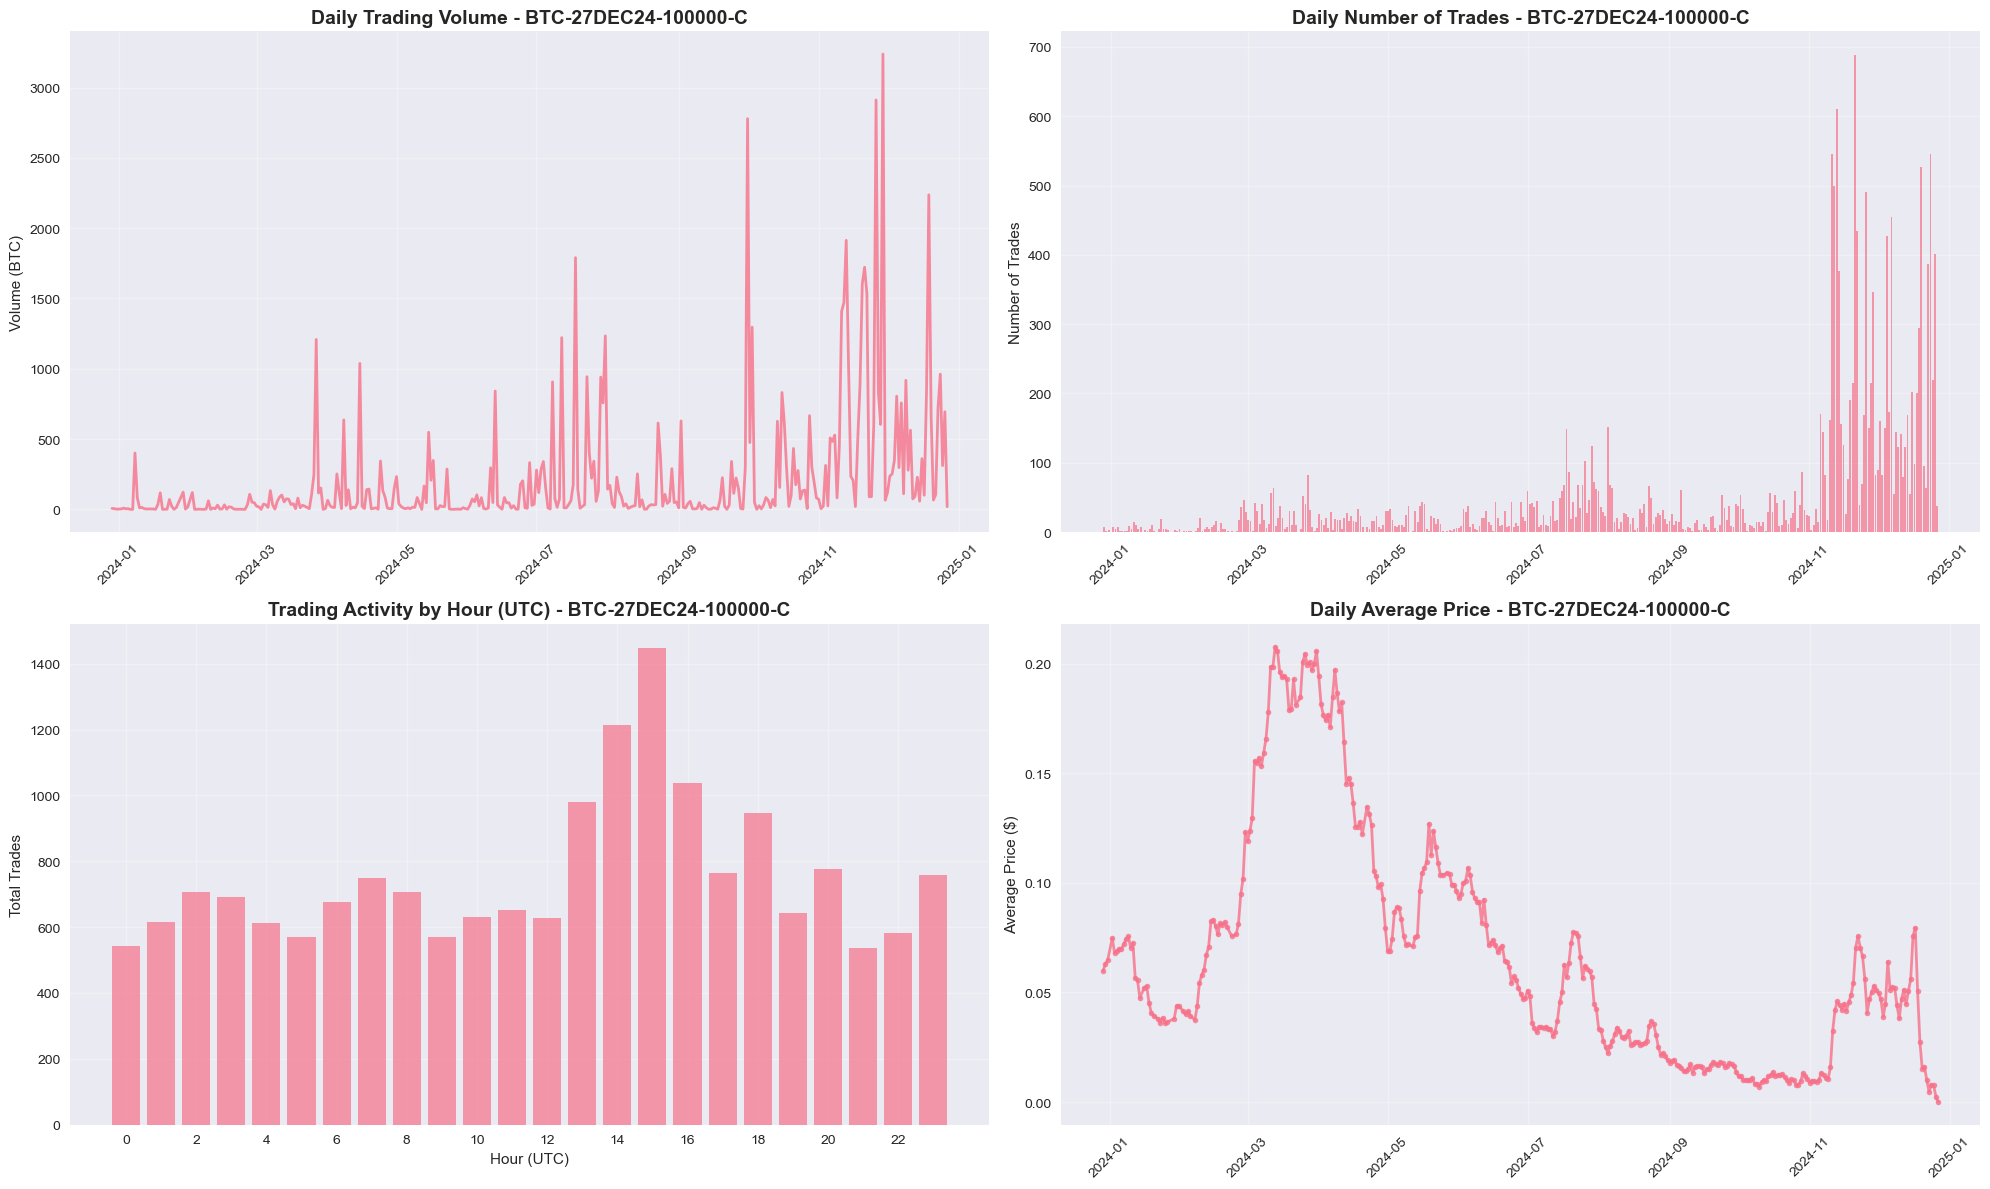


TRADING STATISTICS for BTC-27DEC24-100000-C:
   Total volume: 74524.90 BTC
   Average daily volume: 211.72 BTC
   Peak daily volume: 3238.20 BTC on 2024-11-29
   Average daily trades: 51
   Peak daily trades: 688 on 2024-11-21
   Most active hour: 15:00 UTC (1449 total trades)


In [6]:
# Create comprehensive trading analysis plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Daily Trading Volume
daily_stats = df_trades.groupby('date').agg({
    'quantity': 'sum',
    'price': ['count', 'mean'],
    'datetime': ['min', 'max']
}).round(4)

daily_stats.columns = ['volume', 'trades', 'avg_price', 'first_trade', 'last_trade']
daily_stats.index = pd.to_datetime(daily_stats.index)

ax1.plot(daily_stats.index, daily_stats['volume'], alpha=0.8, linewidth=2)
ax1.set_title(f'Daily Trading Volume - {option_name}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Volume (BTC)')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Daily Number of Trades
ax2.bar(daily_stats.index, daily_stats['trades'], alpha=0.7, width=0.8)
ax2.set_title(f'Daily Number of Trades - {option_name}', fontsize=14, fontweight='bold')
ax2.set_ylabel('Number of Trades')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Hourly Trading Activity
hourly_trades = df_trades.groupby('hour').size()
ax3.bar(hourly_trades.index, hourly_trades.values, alpha=0.7)
ax3.set_title(f'Trading Activity by Hour (UTC) - {option_name}', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hour (UTC)')
ax3.set_ylabel('Total Trades')
ax3.set_xticks(range(0, 24, 2))
ax3.grid(True, alpha=0.3)

# 4. Price Evolution
ax4.plot(daily_stats.index, daily_stats['avg_price'], 'o-', alpha=0.8, linewidth=2, markersize=4)
ax4.set_title(f'Daily Average Price - {option_name}', fontsize=14, fontweight='bold')
ax4.set_ylabel('Average Price ($)')
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nTRADING STATISTICS for {option_name}:")
print(f"   Total volume: {daily_stats['volume'].sum():.2f} BTC")
print(f"   Average daily volume: {daily_stats['volume'].mean():.2f} BTC")
print(f"   Peak daily volume: {daily_stats['volume'].max():.2f} BTC on {daily_stats['volume'].idxmax().date()}")
print(f"   Average daily trades: {daily_stats['trades'].mean():.0f}")
print(f"   Peak daily trades: {daily_stats['trades'].max()} on {daily_stats['trades'].idxmax().date()}")
print(f"   Most active hour: {hourly_trades.idxmax()}:00 UTC ({hourly_trades.max()} total trades)")

## 4. Price and Volatility Analysis

In [7]:
# Calculate time to expiry for each trade
expiry_date = pd.to_datetime(most_liquid['expiry_date']).tz_localize('UTC')  # Make timezone-aware
df_trades['days_to_expiry'] = (expiry_date - df_trades['datetime']).dt.days

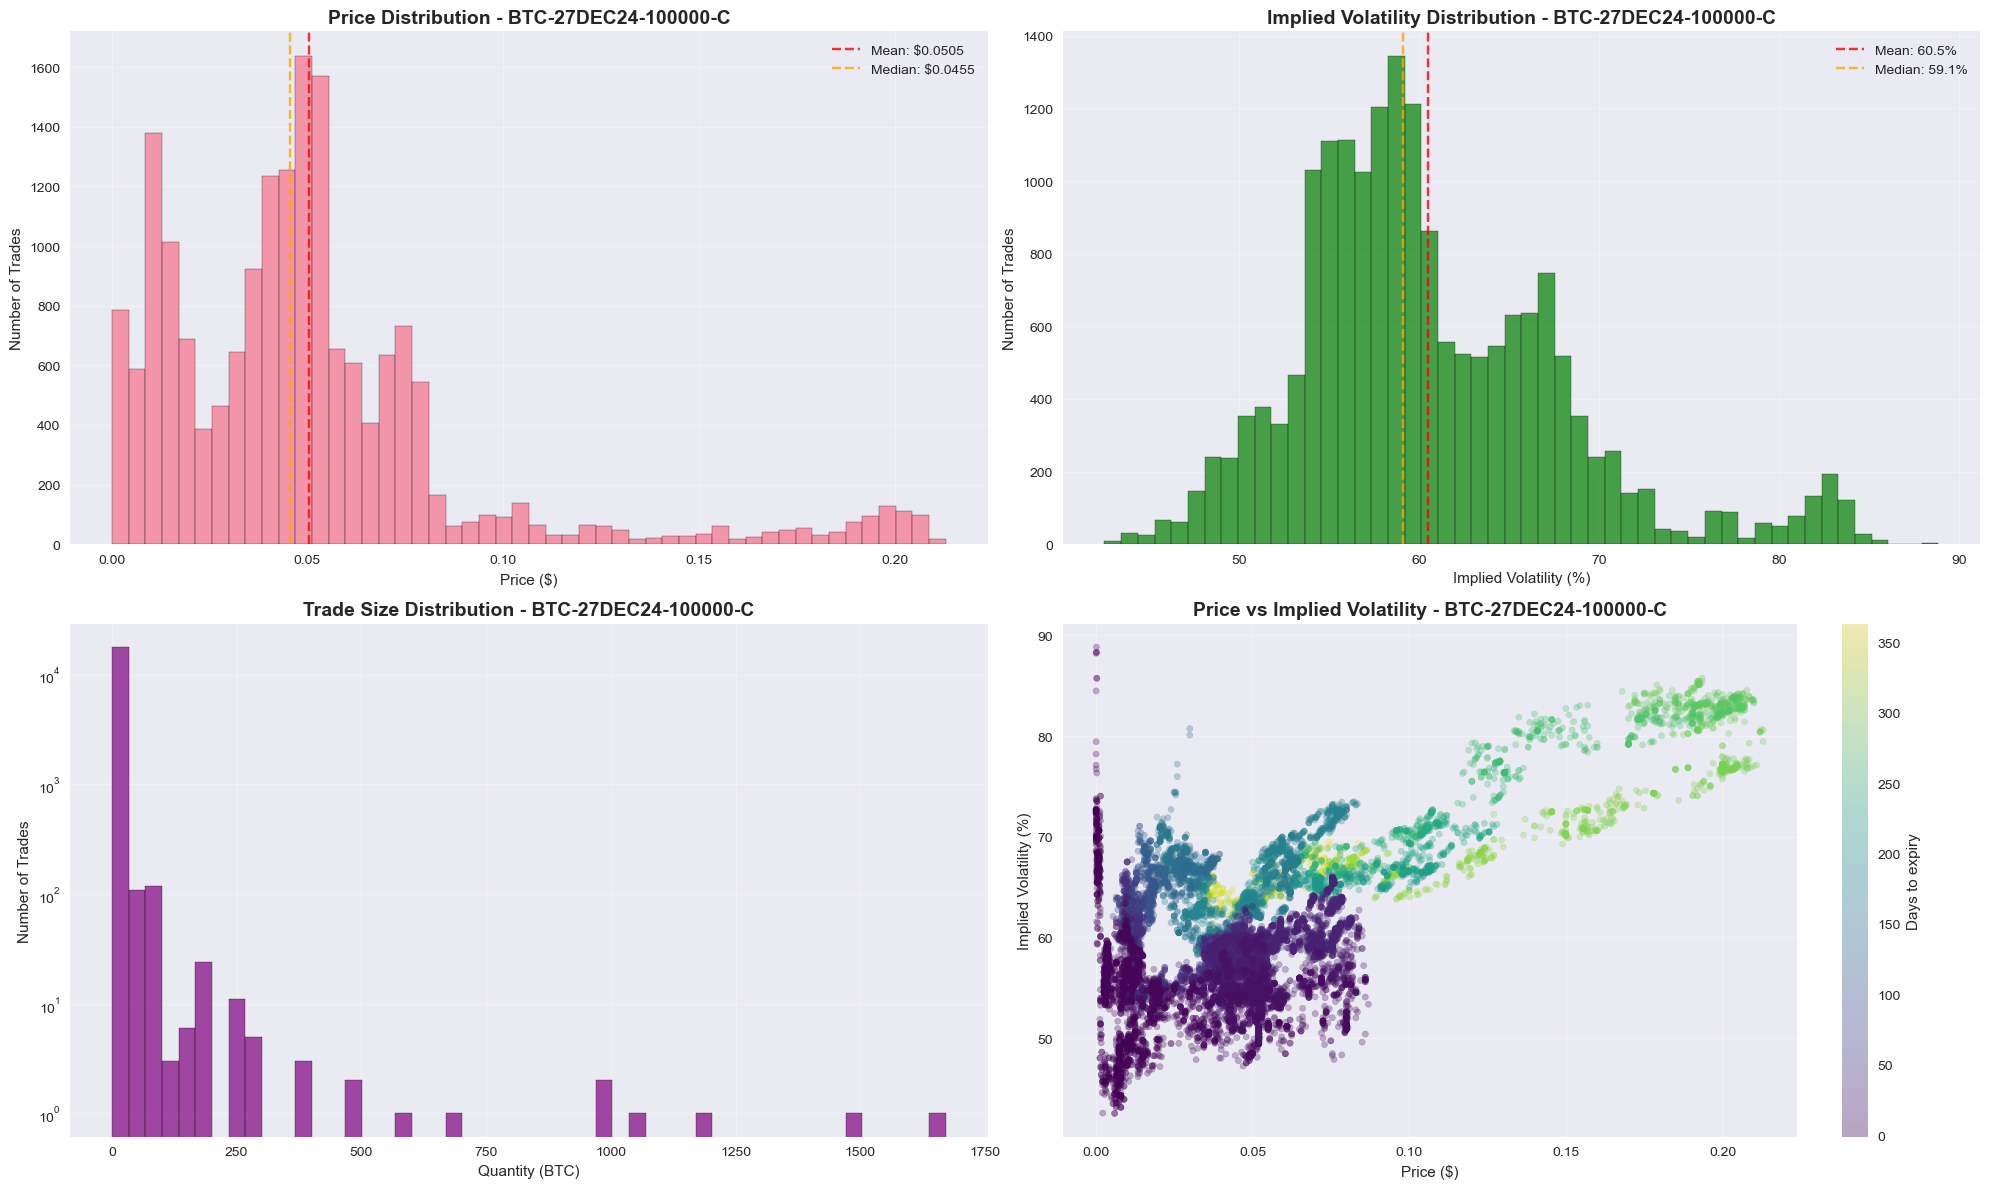


PRICE & VOLATILITY STATISTICS for BTC-27DEC24-100000-C:
   Price range: $0.0001 - $0.2130
   Price volatility: 0.0405
   IV range: 42.5% - 88.8%
   Average trade size: 4.1297 BTC
   Largest trade: 1671.3000 BTC
   Buy/Sell ratio: 8596/9450 (buy/sell)


In [8]:
# Detailed price and volatility analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Price Distribution
ax1.hist(df_trades['price'], bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(df_trades['price'].mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: ${df_trades["price"].mean():.4f}')
ax1.axvline(df_trades['price'].median(), color='orange', linestyle='--', alpha=0.8, label=f'Median: ${df_trades["price"].median():.4f}')
ax1.set_title(f'Price Distribution - {option_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Price ($)')
ax1.set_ylabel('Number of Trades')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Implied Volatility Distribution
ax2.hist(df_trades['iv'], bins=50, alpha=0.7, edgecolor='black', color='green')
ax2.axvline(df_trades['iv'].mean(), color='red', linestyle='--', alpha=0.8, label=f'Mean: {df_trades["iv"].mean():.1f}%')
ax2.axvline(df_trades['iv'].median(), color='orange', linestyle='--', alpha=0.8, label=f'Median: {df_trades["iv"].median():.1f}%')
ax2.set_title(f'Implied Volatility Distribution - {option_name}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Implied Volatility (%)')
ax2.set_ylabel('Number of Trades')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Trade Size Distribution
ax3.hist(df_trades['quantity'], bins=50, alpha=0.7, edgecolor='black', color='purple')
ax3.set_title(f'Trade Size Distribution - {option_name}', fontsize=14, fontweight='bold')
ax3.set_xlabel('Quantity (BTC)')
ax3.set_ylabel('Number of Trades')
ax3.set_yscale('log')  # Log scale for better visibility
ax3.grid(True, alpha=0.3)

# 4. Price vs IV Scatter
scatter = ax4.scatter(df_trades['price'], df_trades['iv'], alpha=0.3, s=20, c=df_trades["days_to_expiry"], cmap='viridis')
ax4.set_title(f'Price vs Implied Volatility - {option_name}', fontsize=14, fontweight='bold')
ax4.set_xlabel('Price ($)')
ax4.set_ylabel('Implied Volatility (%)')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Days to expiry')

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nPRICE & VOLATILITY STATISTICS for {option_name}:")
print(f"   Price range: ${df_trades['price'].min():.4f} - ${df_trades['price'].max():.4f}")
print(f"   Price volatility: {df_trades['price'].std():.4f}")
print(f"   IV range: {df_trades['iv'].min():.1f}% - {df_trades['iv'].max():.1f}%")
print(f"   Average trade size: {df_trades['quantity'].mean():.4f} BTC")
print(f"   Largest trade: {df_trades['quantity'].max():.4f} BTC")
print(f"   Buy/Sell ratio: {(~df_trades['is_buyer_maker']).sum()}/{df_trades['is_buyer_maker'].sum()} (buy/sell)")

## 5. Time-to-Expiry Analysis

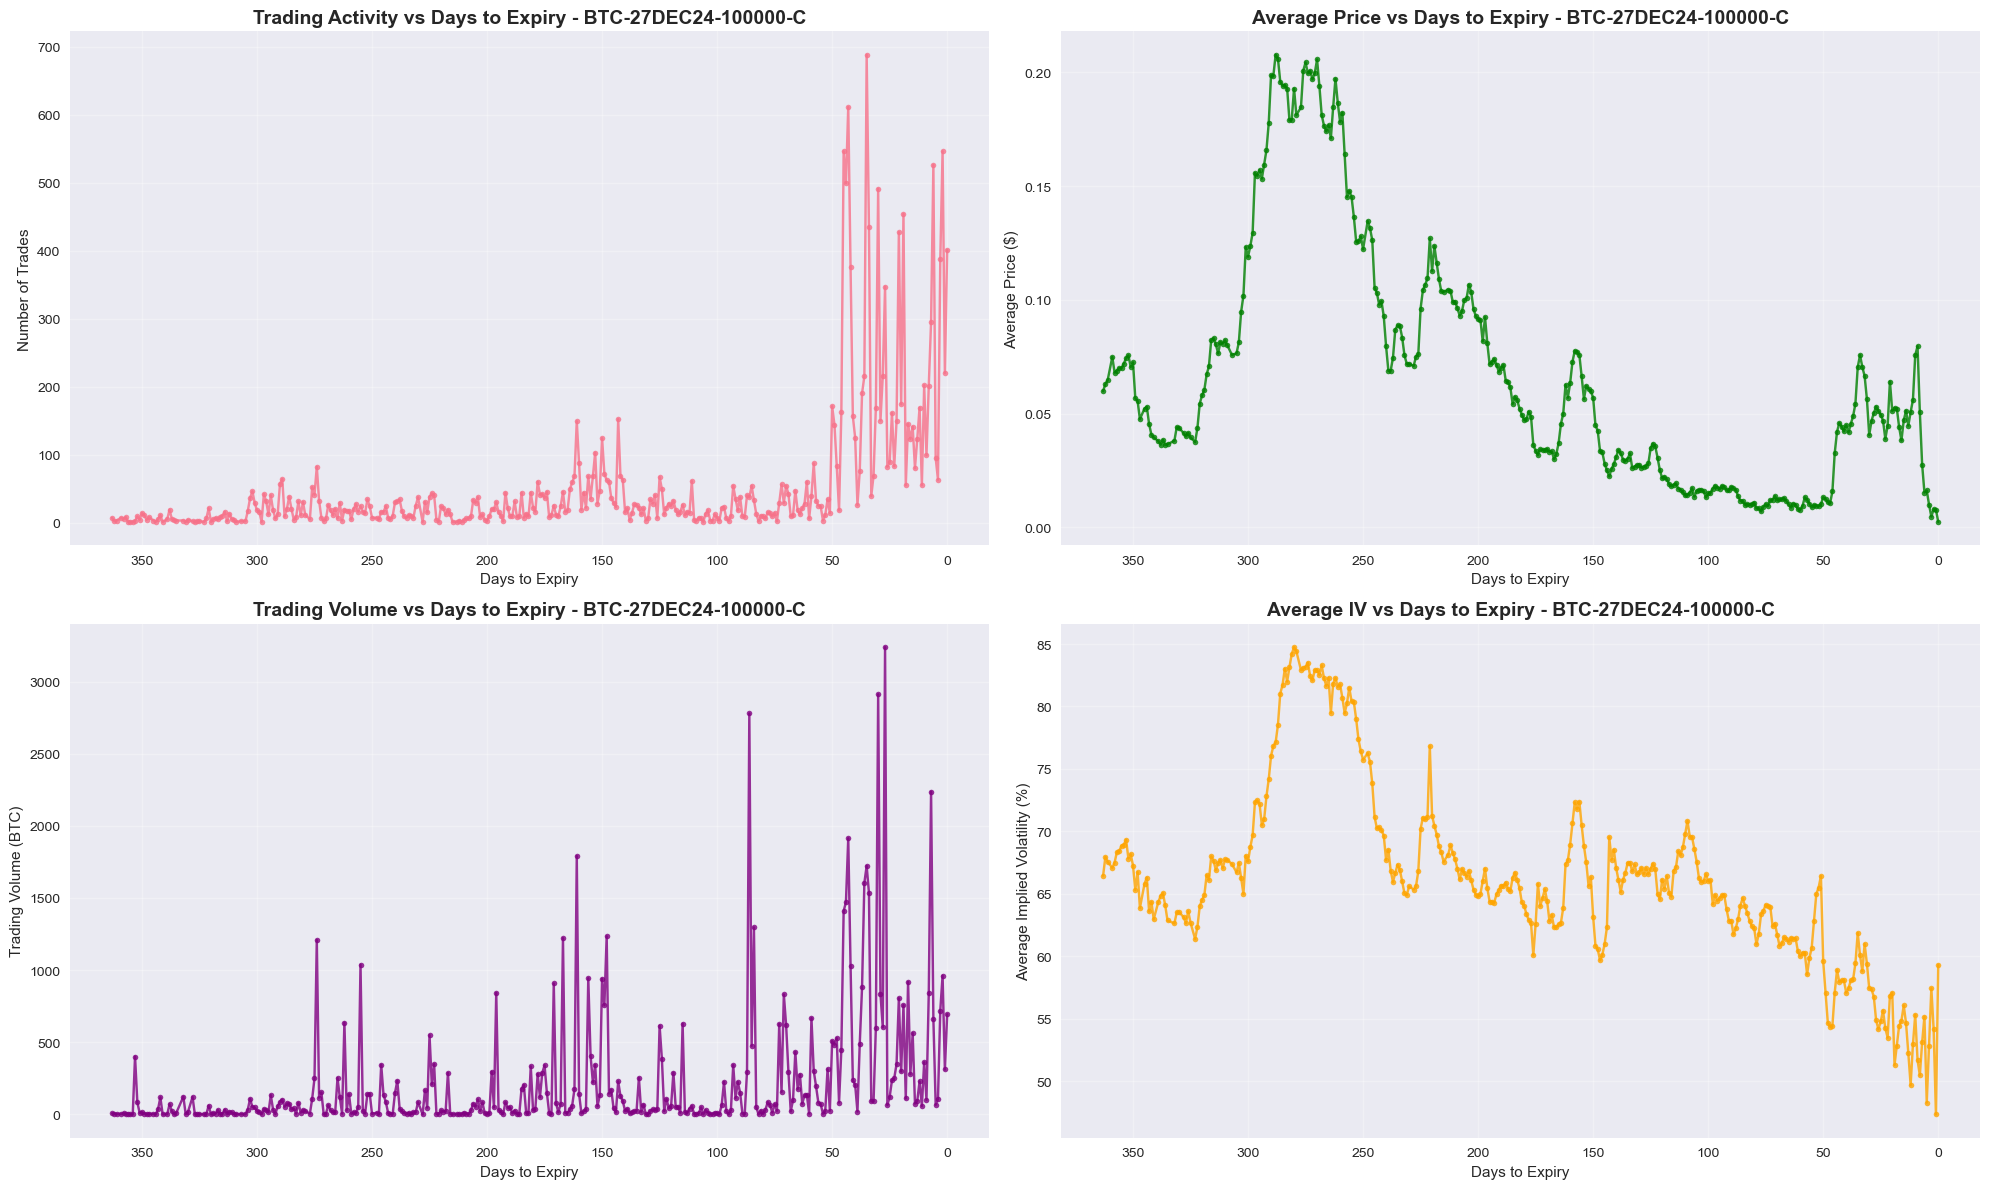


TIME-TO-EXPIRY INSIGHTS for BTC-27DEC24-100000-C:
   Most active period: 35 days before expiry (688 trades)
   Highest volume period: 27 days before expiry (3238.20 BTC)
   Price trend: 0.0024 → 0.0599 (early → late)
   IV trend: 59.3% → 66.4% (early → late)


In [9]:
# Group by days to expiry
expiry_analysis = df_trades.groupby('days_to_expiry').agg({
    'price': ['count', 'mean', 'std'],
    'quantity': 'sum',
    'iv': 'mean'
}).round(4)

expiry_analysis.columns = ['trades', 'avg_price', 'price_std', 'volume', 'avg_iv']
expiry_analysis = expiry_analysis[expiry_analysis.index >= 0]  # Only positive days to expiry

# Create time-to-expiry plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# 1. Trading activity vs time to expiry
ax1.plot(expiry_analysis.index, expiry_analysis['trades'], 'o-', alpha=0.8, markersize=4)
ax1.set_title(f'Trading Activity vs Days to Expiry - {option_name}', fontsize=14, fontweight='bold')
ax1.set_xlabel('Days to Expiry')
ax1.set_ylabel('Number of Trades')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Show approaching expiry

# 2. Average price vs time to expiry
ax2.plot(expiry_analysis.index, expiry_analysis['avg_price'], 'o-', alpha=0.8, markersize=4, color='green')
ax2.set_title(f'Average Price vs Days to Expiry - {option_name}', fontsize=14, fontweight='bold')
ax2.set_xlabel('Days to Expiry')
ax2.set_ylabel('Average Price ($)')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

# 3. Volume vs time to expiry
ax3.plot(expiry_analysis.index, expiry_analysis['volume'], 'o-', alpha=0.8, markersize=4, color='purple')
ax3.set_title(f'Trading Volume vs Days to Expiry - {option_name}', fontsize=14, fontweight='bold')
ax3.set_xlabel('Days to Expiry')
ax3.set_ylabel('Trading Volume (BTC)')
ax3.grid(True, alpha=0.3)
ax3.invert_xaxis()

# 4. Implied volatility vs time to expiry
ax4.plot(expiry_analysis.index, expiry_analysis['avg_iv'], 'o-', alpha=0.8, markersize=4, color='orange')
ax4.set_title(f'Average IV vs Days to Expiry - {option_name}', fontsize=14, fontweight='bold')
ax4.set_xlabel('Days to Expiry')
ax4.set_ylabel('Average Implied Volatility (%)')
ax4.grid(True, alpha=0.3)
ax4.invert_xaxis()

plt.tight_layout()
plt.show()

# Summary insights
print(f"\nTIME-TO-EXPIRY INSIGHTS for {option_name}:")
print(f"   Most active period: {expiry_analysis['trades'].idxmax()} days before expiry ({expiry_analysis['trades'].max()} trades)")
print(f"   Highest volume period: {expiry_analysis['volume'].idxmax()} days before expiry ({expiry_analysis['volume'].max():.2f} BTC)")
print(f"   Price trend: {expiry_analysis['avg_price'].iloc[0]:.4f} → {expiry_analysis['avg_price'].iloc[-1]:.4f} (early → late)")
print(f"   IV trend: {expiry_analysis['avg_iv'].iloc[0]:.1f}% → {expiry_analysis['avg_iv'].iloc[-1]:.1f}% (early → late)")